In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
from arch import arch_model

import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime

#import gspread as gs

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
# Diciconarie of abailable stocks/indexes with page reference of the excel file
# This can be replaced with direct download from yfinance
dic = pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\Datos BBG.xlsx', sheet_name=5)
dic

,Index
0,Merval
1,MADX
2,FTSE MIB
3,DAX
4,UKX


In [3]:
# ID : assign one of the numbers in "dic" to work with the choosen stock
id = 1

In [4]:
# Import data. Generates data_backup with original data. 
# mer: includes trade volume, Interest rate and M2 money supply in case to be included
# dpx : generates a dataframe only with price and returns. Also adds a column of the 1st difference of prices.
data_backup = pd.read_excel(r'C:\Users\bantenuc\OneDrive - Ternium\Escritorio\BRUNO\Tesis\Datos BBG.xlsx', sheet_name=id) #sheet_name=0 brings first sheet, =1 brings 2nd sheet
mer = data_backup
dpx = mer[['Date','PX','PXret']]
dpx = dpx[dpx['PXret'].notnull()] #generates a new DF with Price and Returns
dpx['PXdiff'] = dpx.PX.diff() # Add a column with 1st differences
dpx = dpx.set_index('Date')
yrl= pd.DataFrame(np.unique(dpx.index.year))#Create a df of years for store data of each year
yrl.rename( columns={0 :'Year'}, inplace=True )
#mer = mer.dropna() #is it ok to drop NaN values
#mer = mer.reset_index()
#mer = mer.drop('index', axis=1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
mer=mer.set_index('Date')
dpx

,PX,PXret,PXdiff
Date,,,
1993-02-19,233.200,0.005,NaN
1993-02-22,232.300,-0.004,-0.900
1993-02-23,227.800,-0.019,-4.500
1993-02-24,227.900,0.000,0.100
1993-02-25,228.000,0.000,0.100
...,...,...,...
2022-12-23,823.570,-0.000,-0.220
2022-12-27,823.830,0.000,0.260
2022-12-28,822.810,-0.001,-1.020


In [5]:
# Describes the characteristics of every variable of the time series.
dpx.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PX,7549.000,874.028,303.371,227.800,745.470,884.430,1035.030,1724.950
PXret,7549.000,0.000,0.014,-0.140,-0.007,0.001,0.007,0.147
PXdiff,7548.000,0.078,12.220,-111.460,-5.353,0.520,5.833,137.540


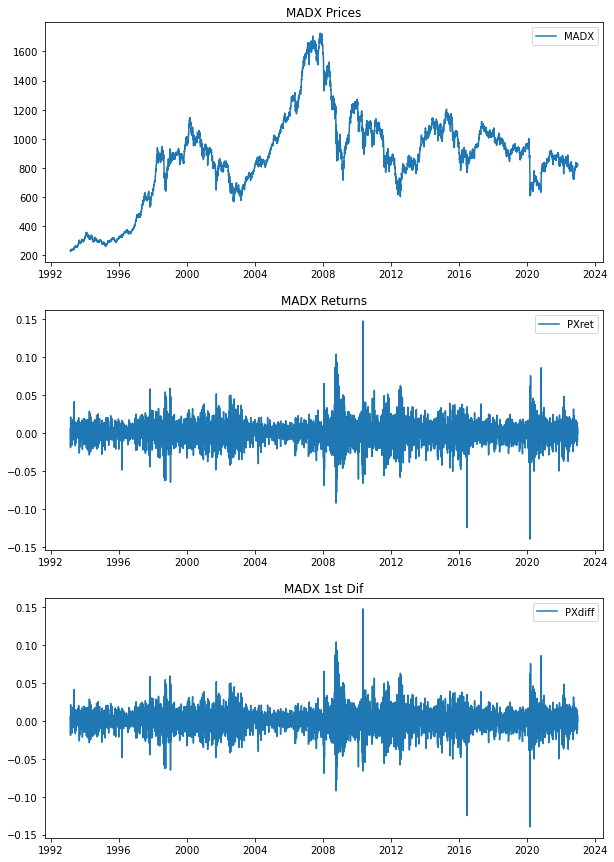

In [6]:
plt.rcParams["figure.figsize"] = (10, 15)

fig, ax = plt.subplots(3,1)


ax[0].plot(dpx.PX, label = dic.Index[id])
ax[0].set_title(dic.Index[id]+" Prices", size = 12)
ax[0].legend()

ax[1].plot(dpx.PXret, label = "PXret")
ax[1].set_title(dic.Index[id]+" Returns", size = 12)
ax[1].legend()

ax[2].plot(dpx.PXret, label = "PXdiff")
ax[2].set_title(dic.Index[id]+" 1st Dif", size = 12)
ax[2].legend()


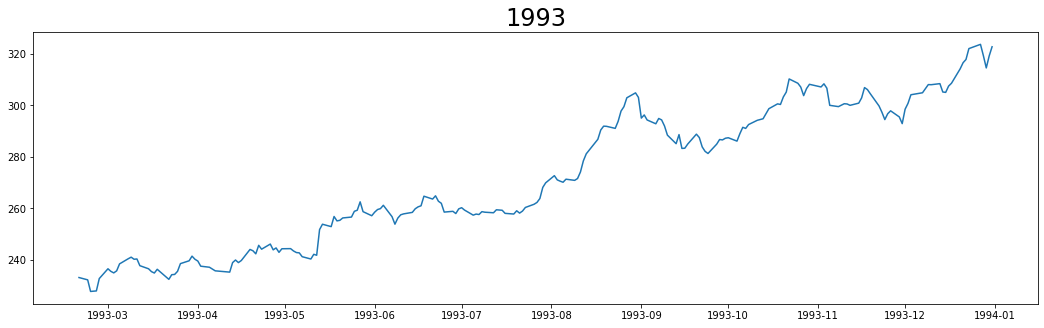

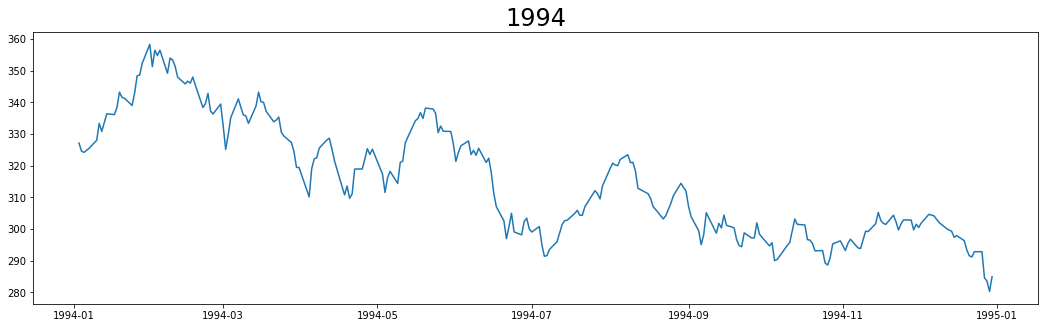

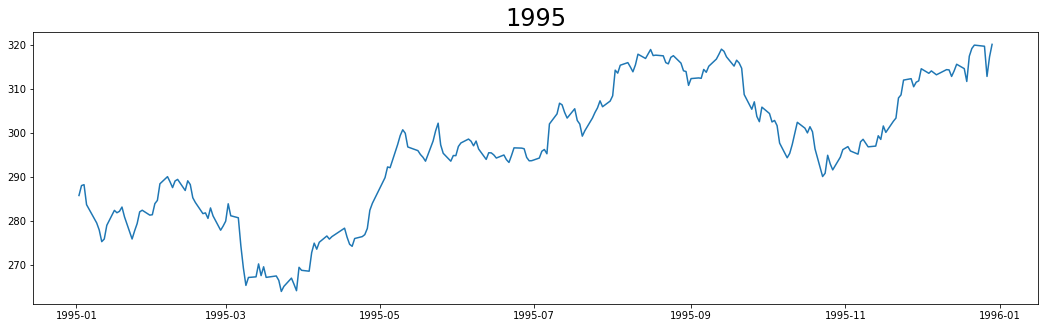

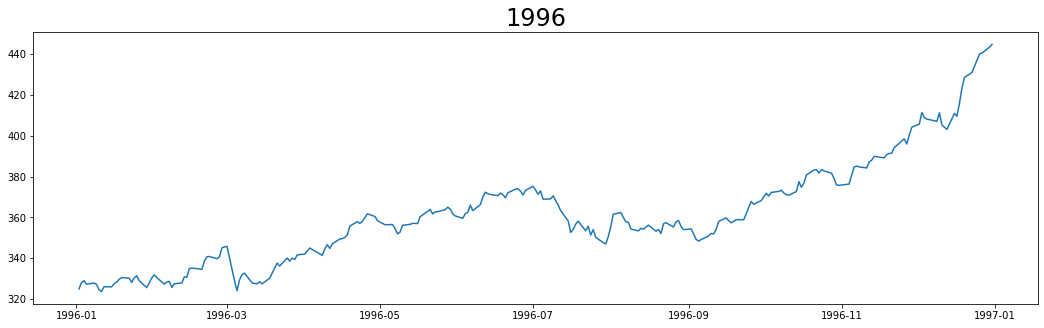

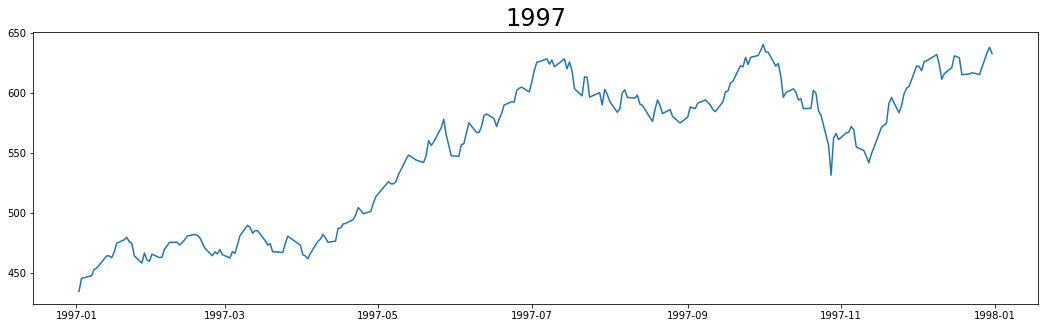

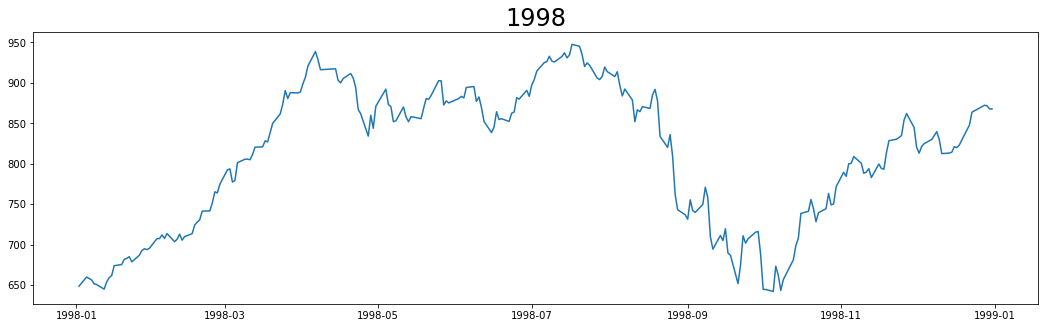

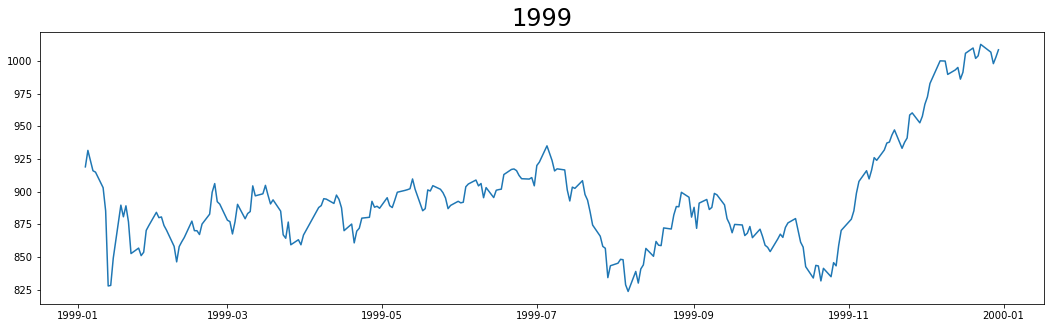

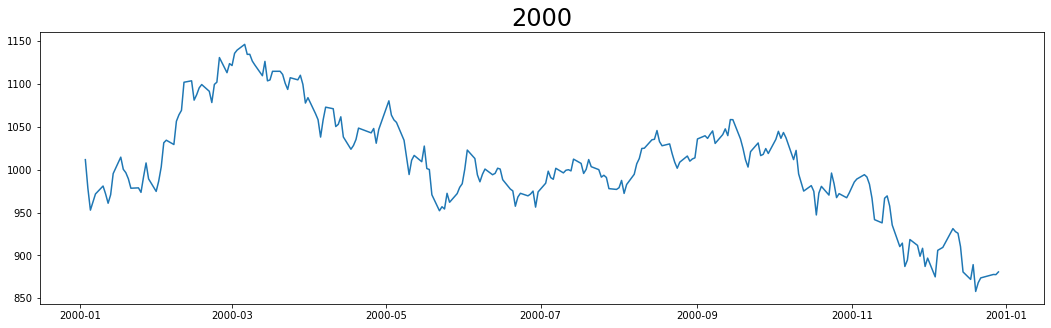

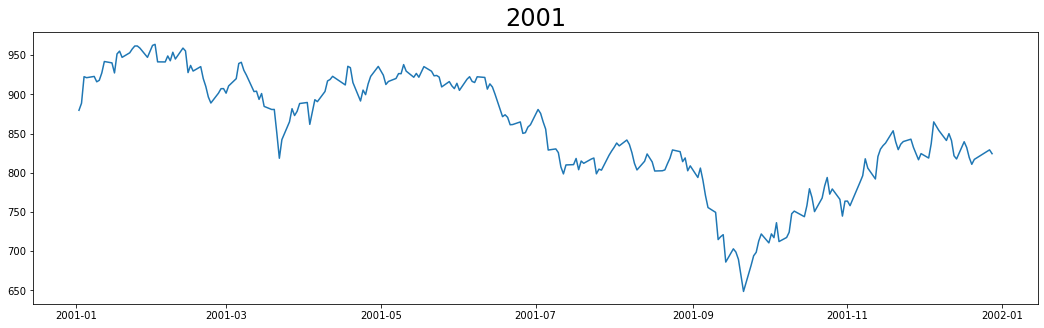

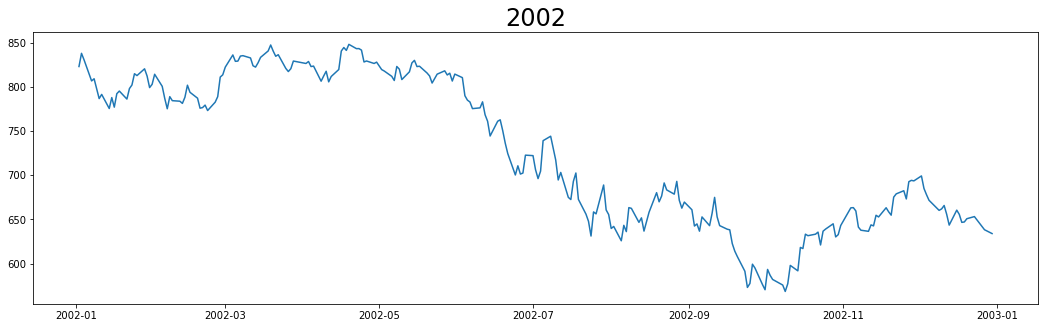

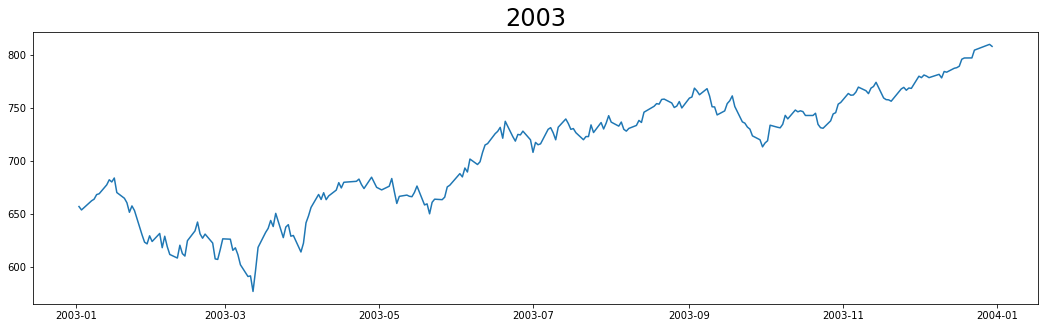

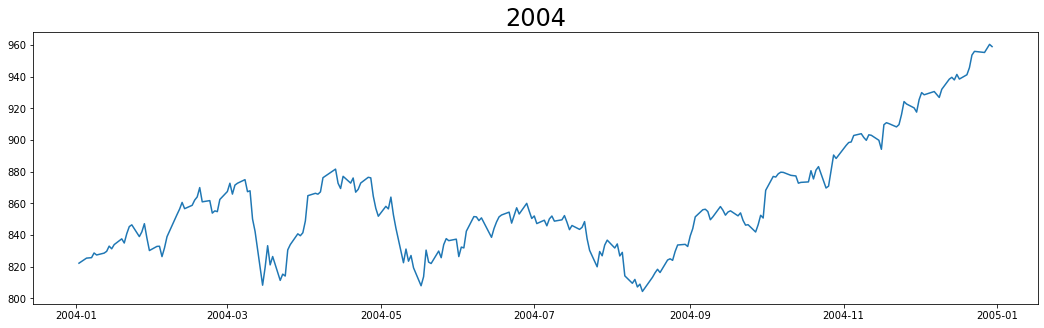

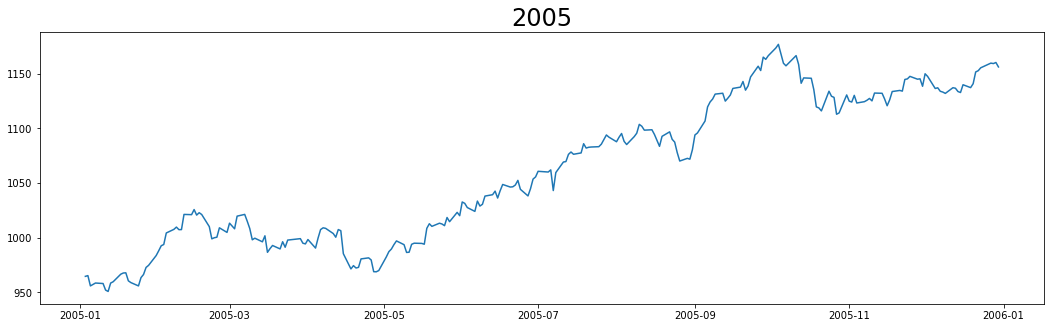

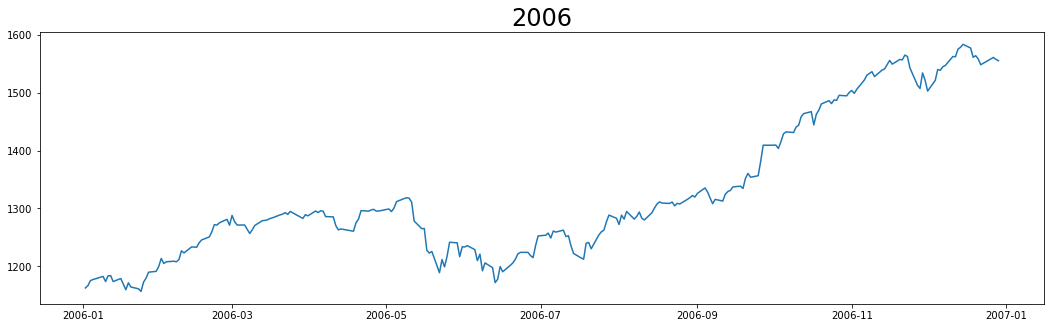

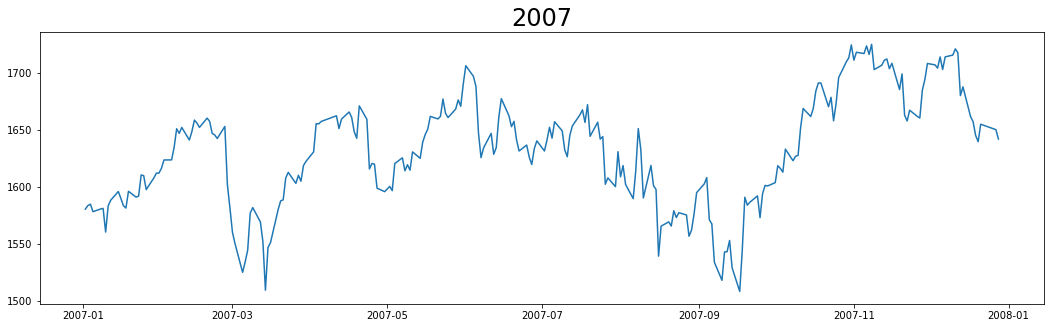

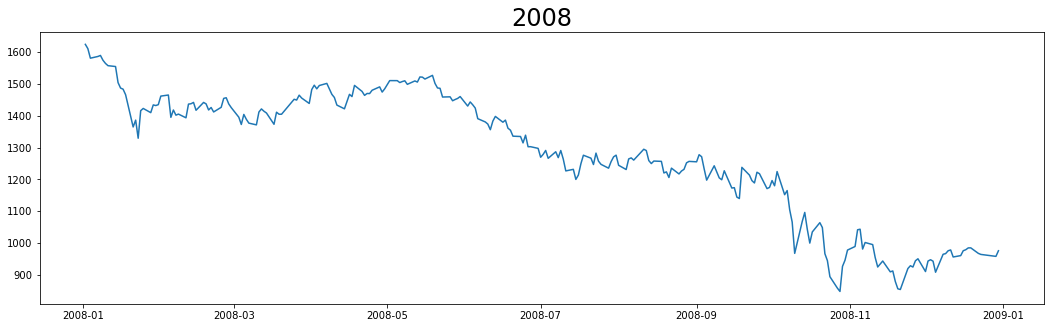

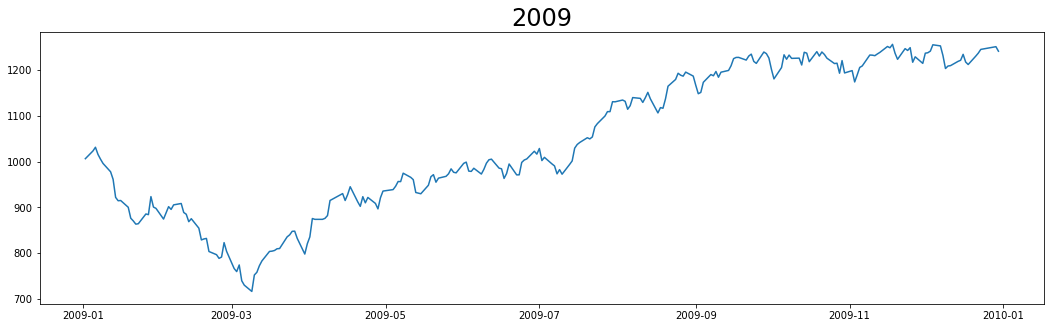

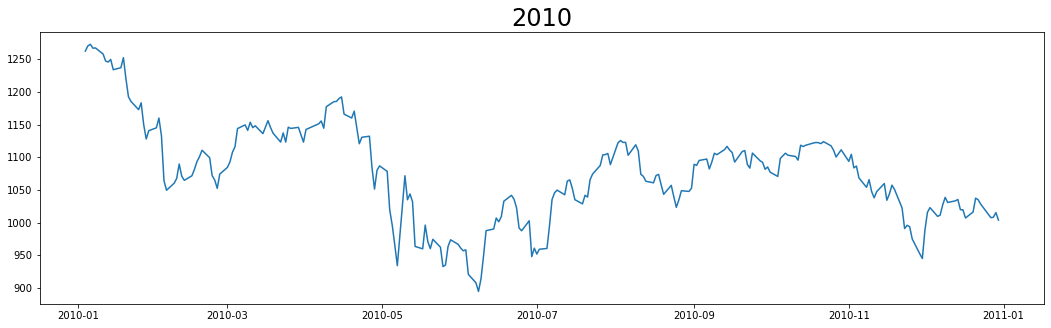

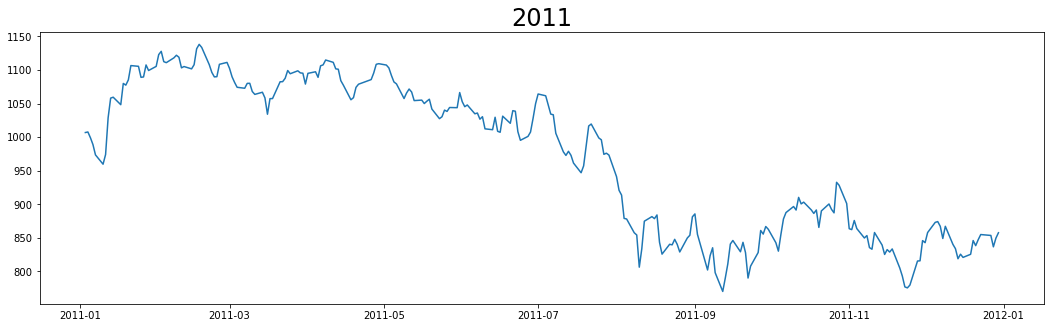

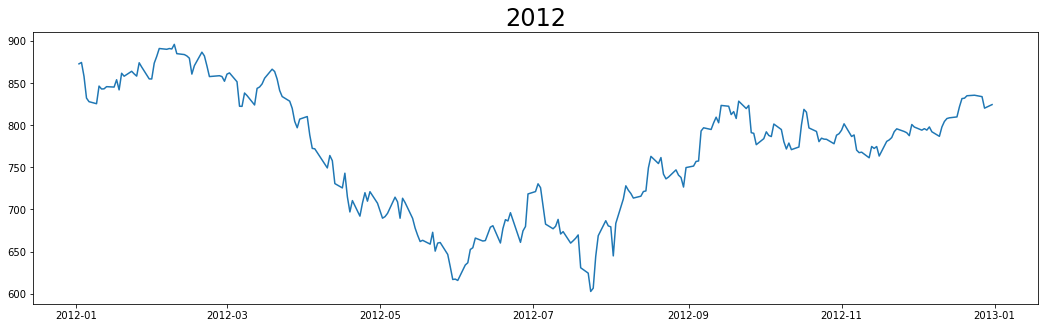

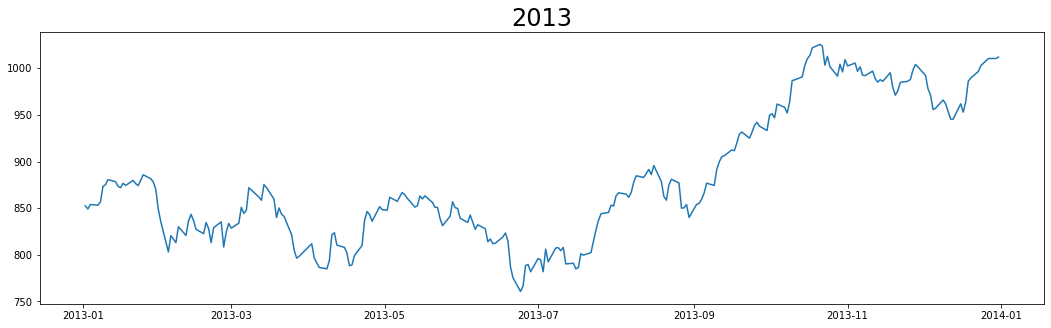

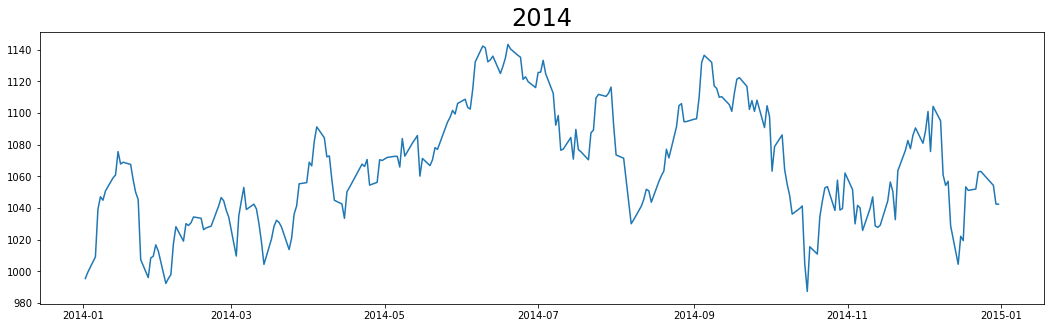

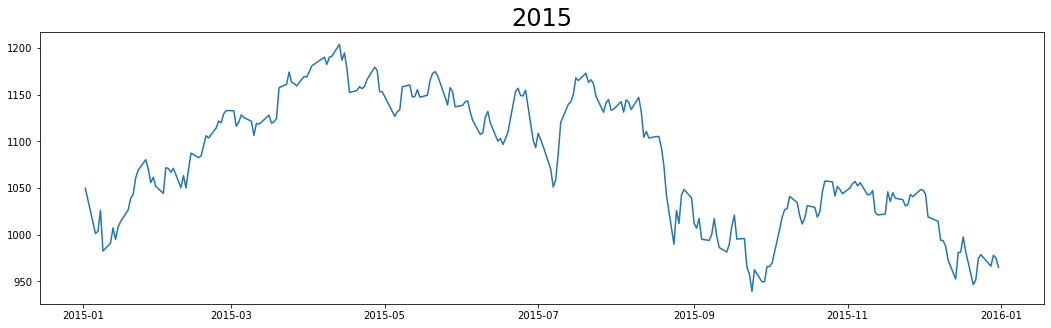

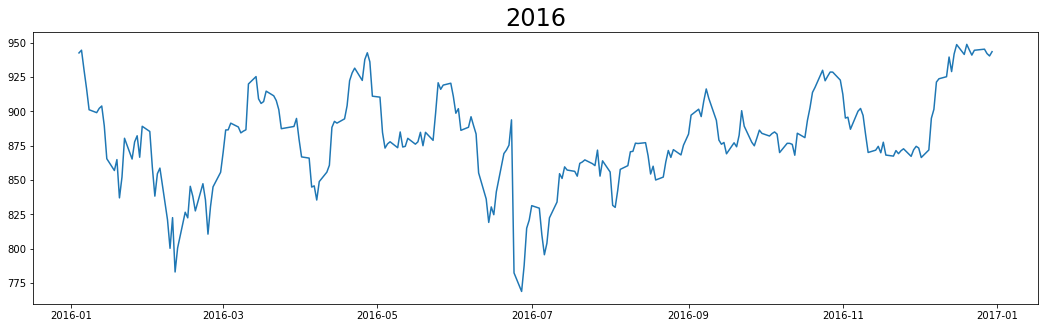

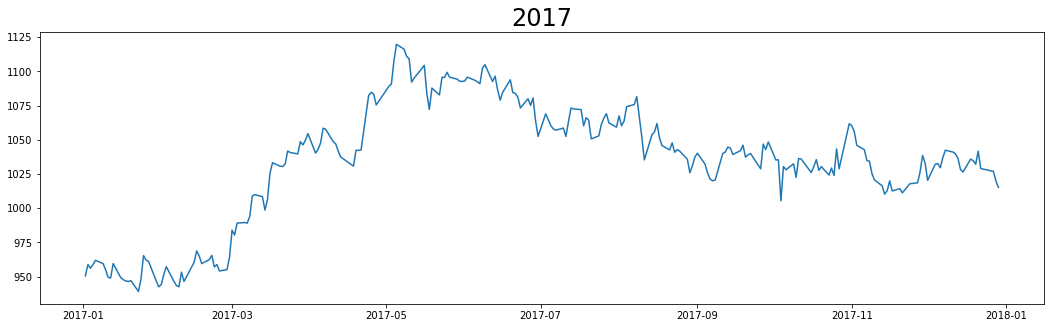

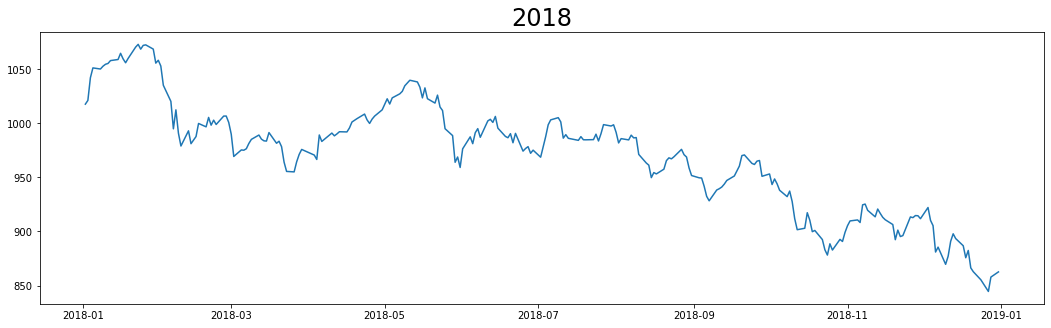

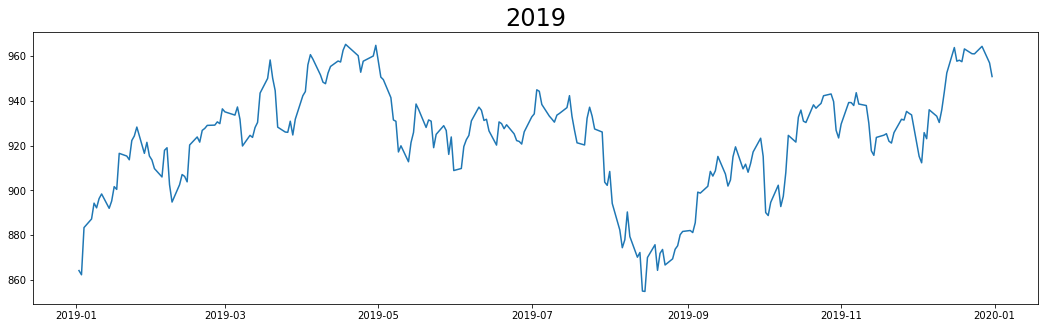

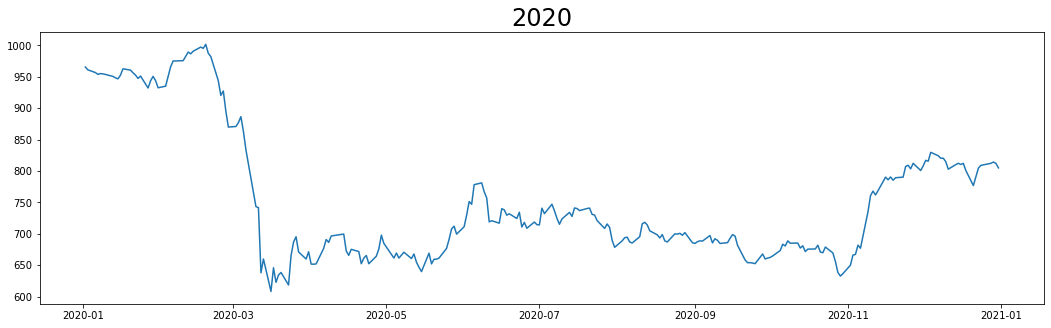

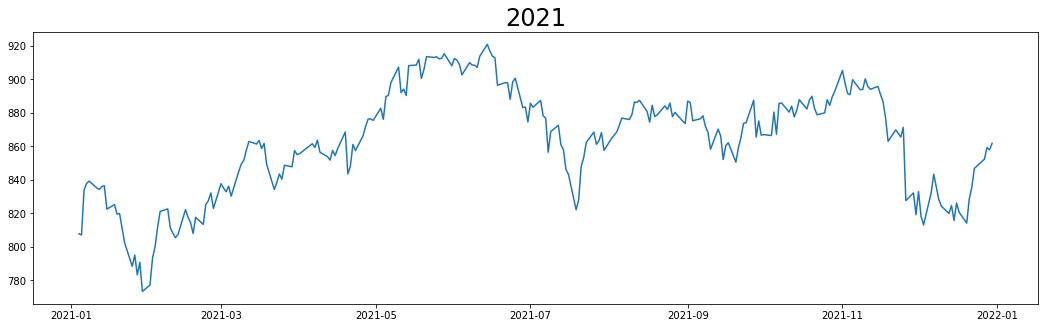

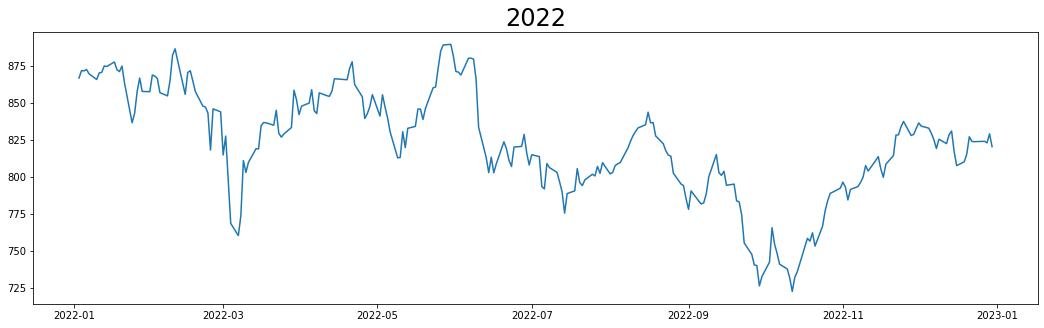

In [7]:
#Plot Prices for every year 

plt.rcParams["figure.figsize"] = 18, 5

for year in set(dpx.index.year):
    plt.plot(dpx[["PX"]].loc[dpx.index.year == year])
    plt.title(str(year), size = 24)
    plt.show()

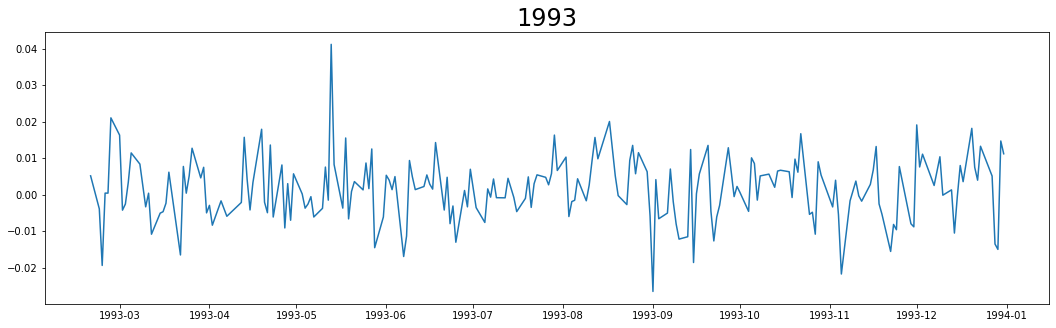

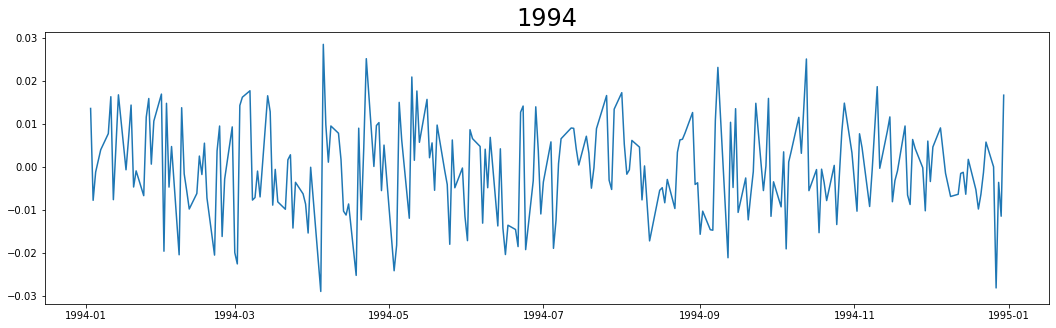

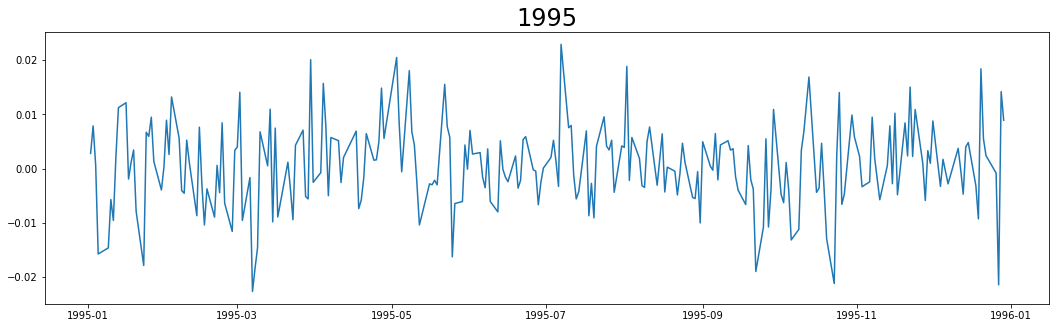

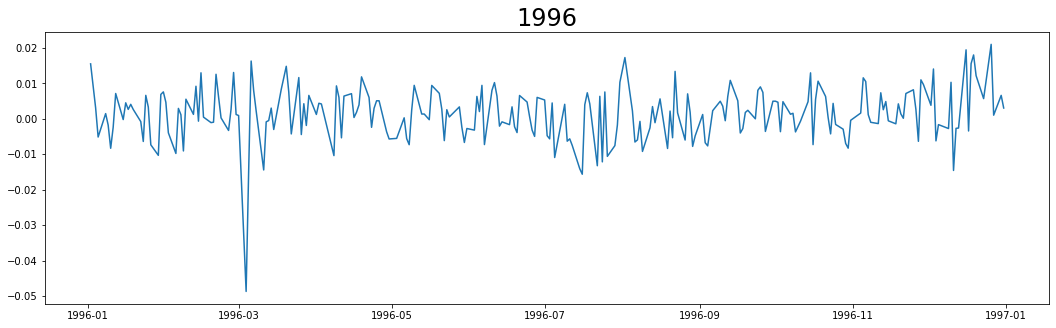

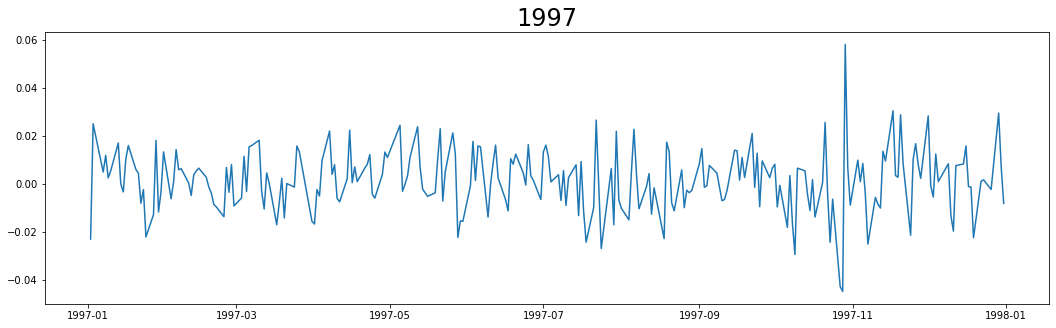

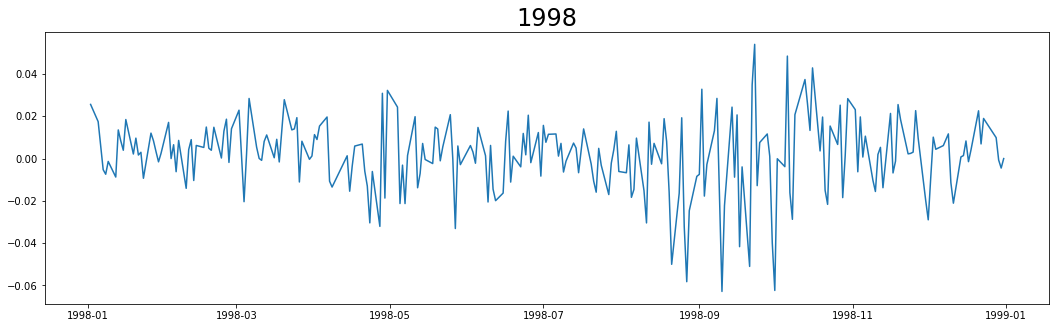

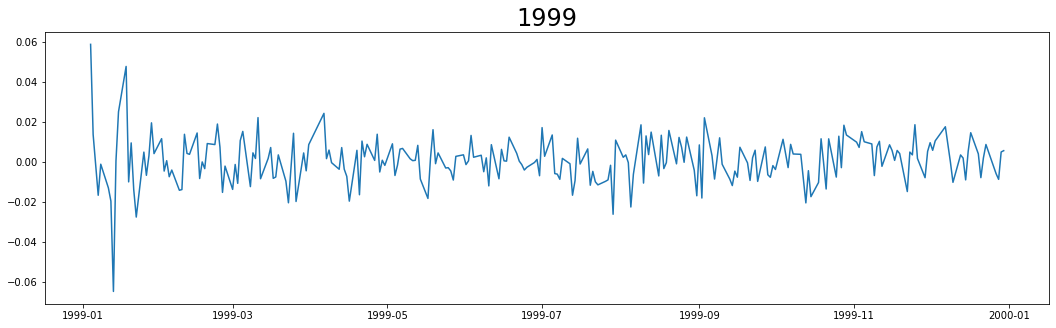

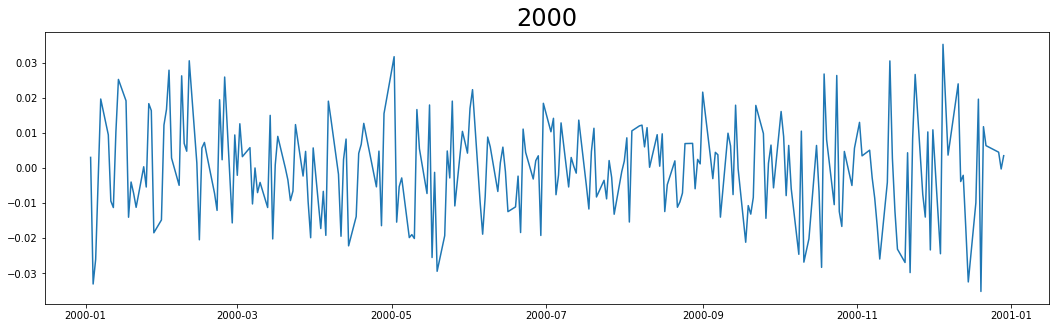

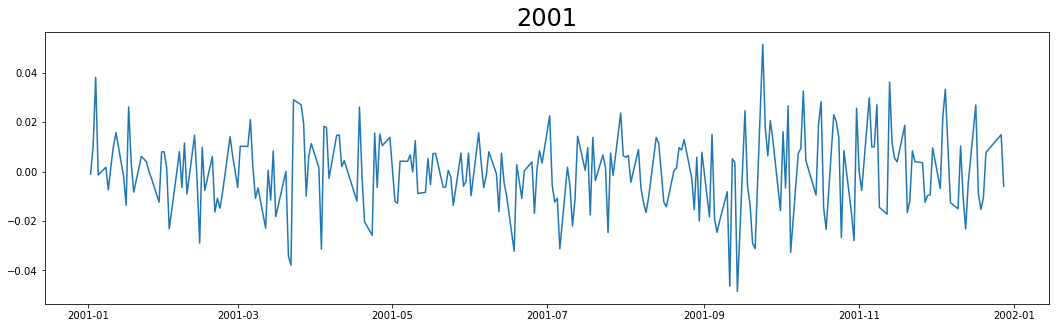

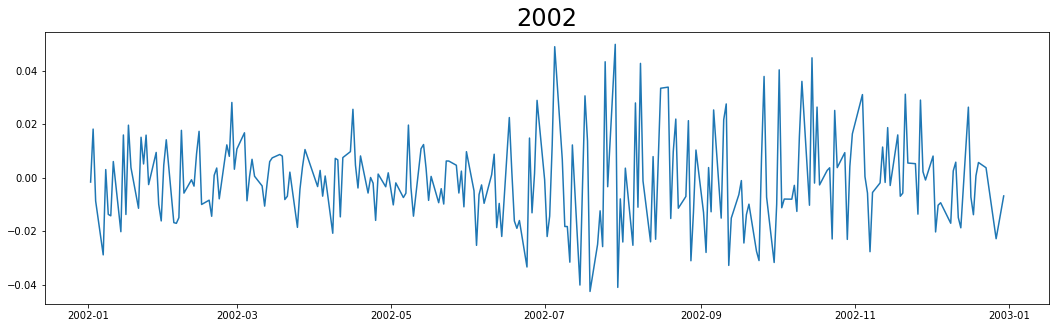

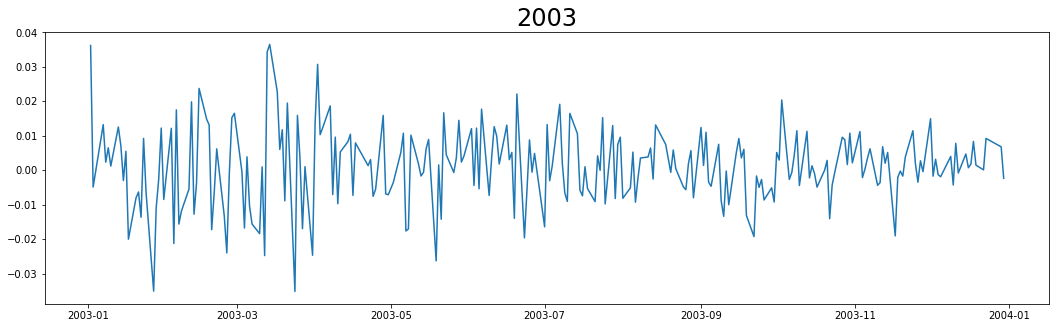

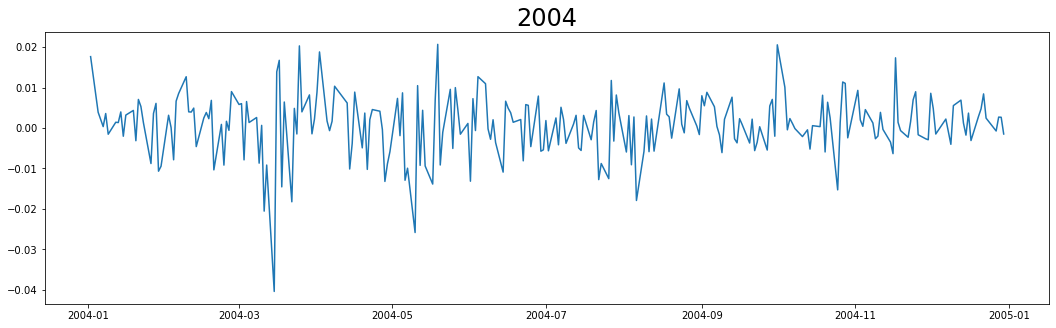

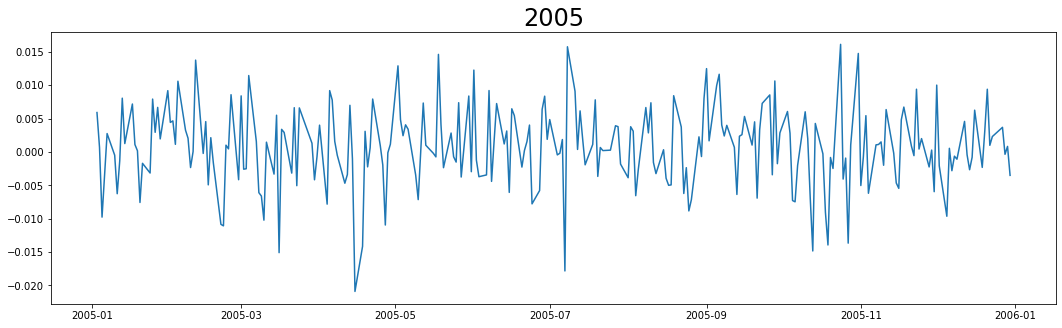

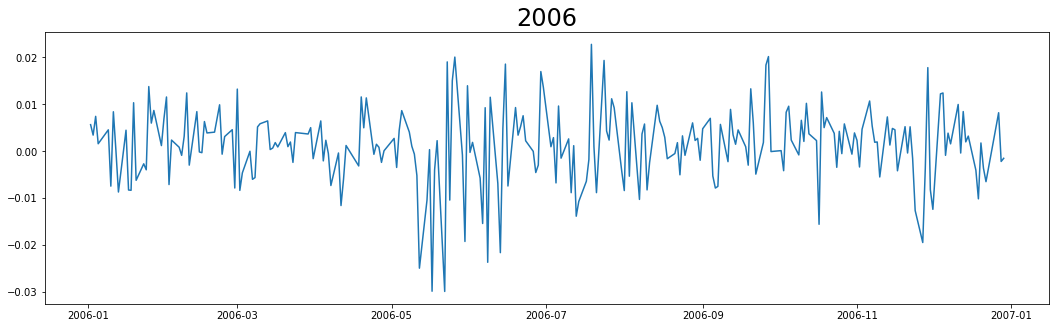

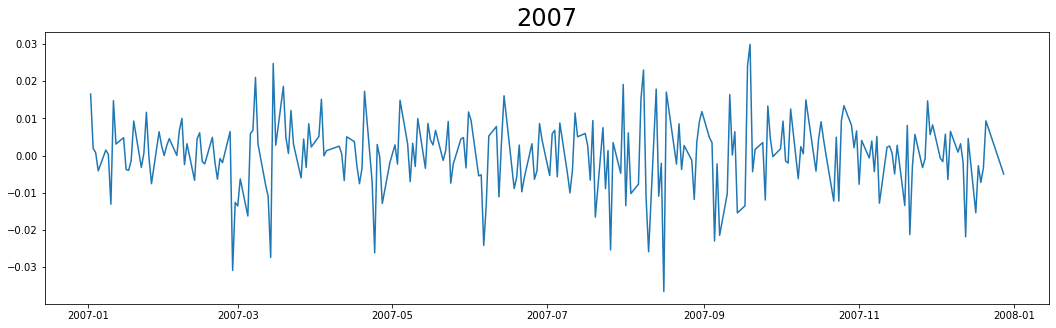

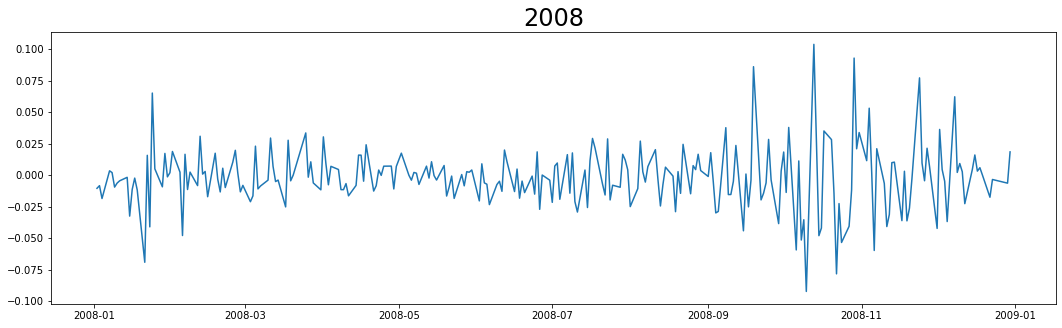

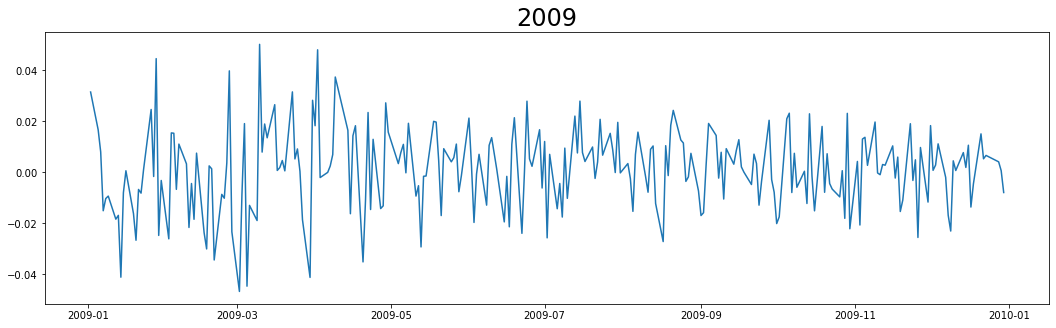

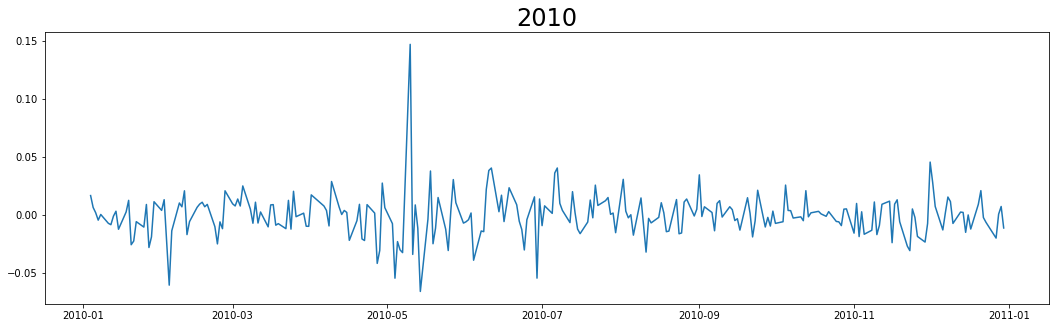

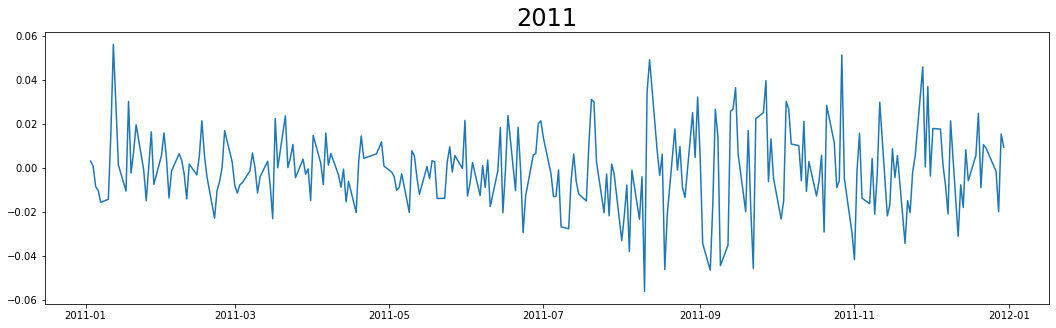

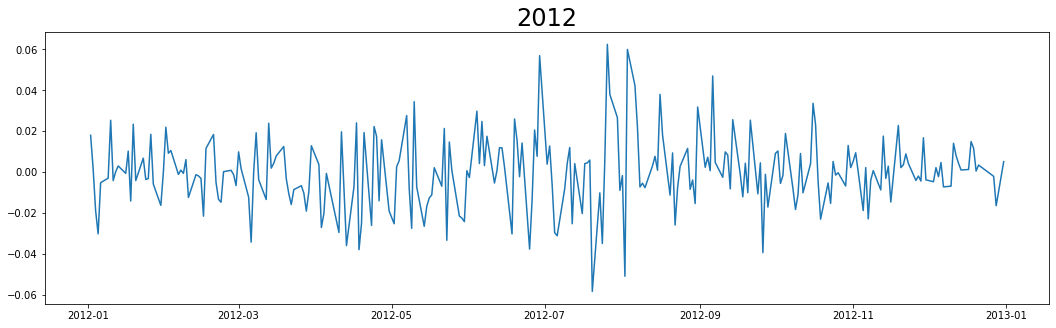

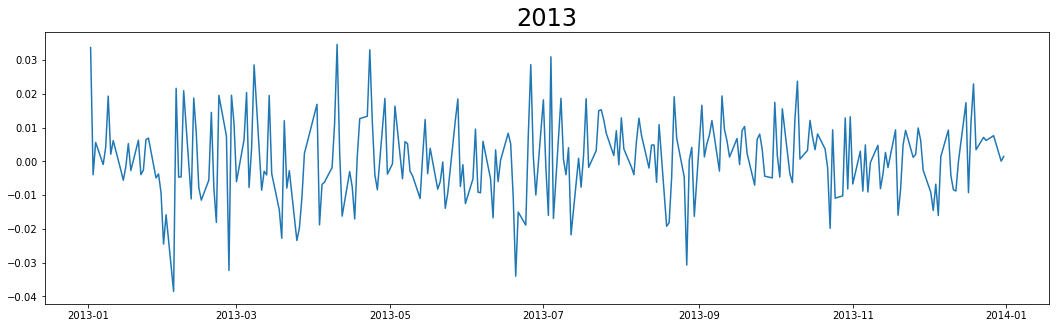

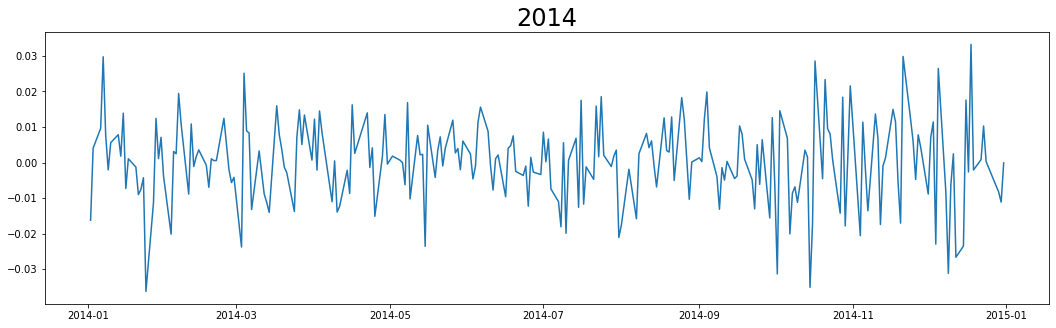

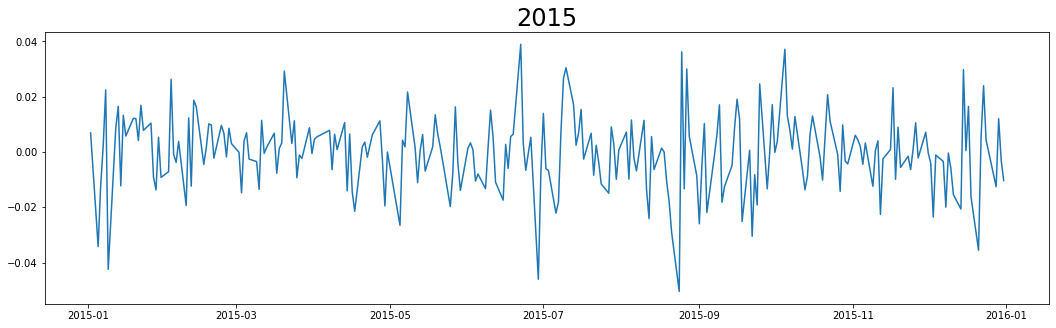

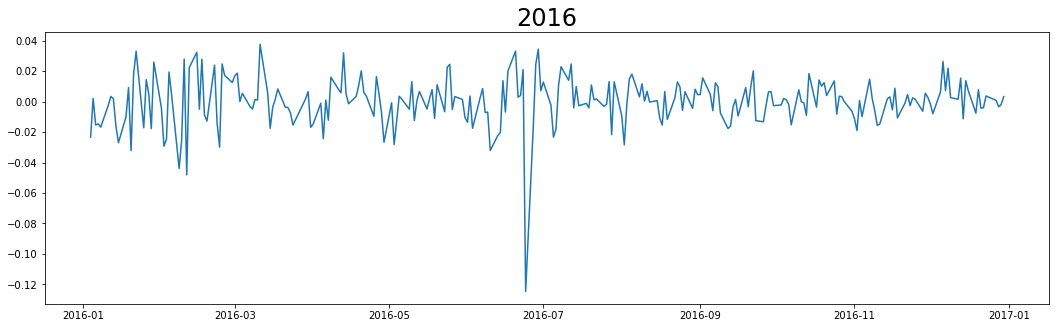

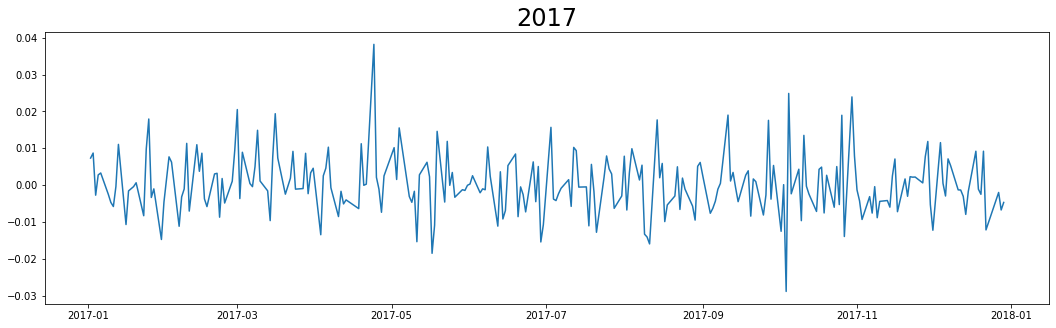

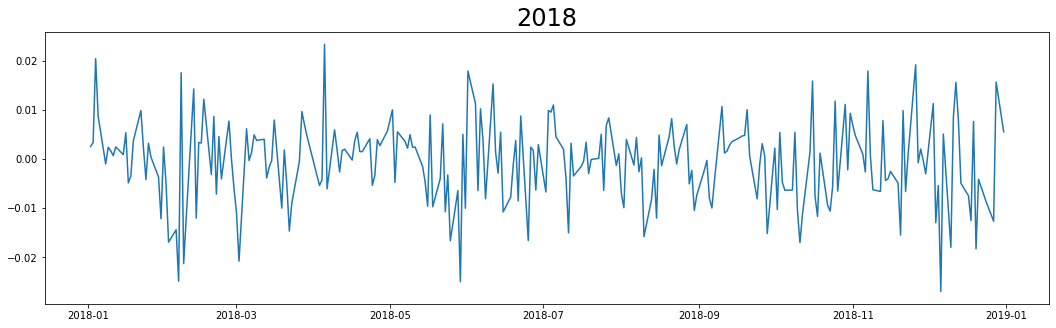

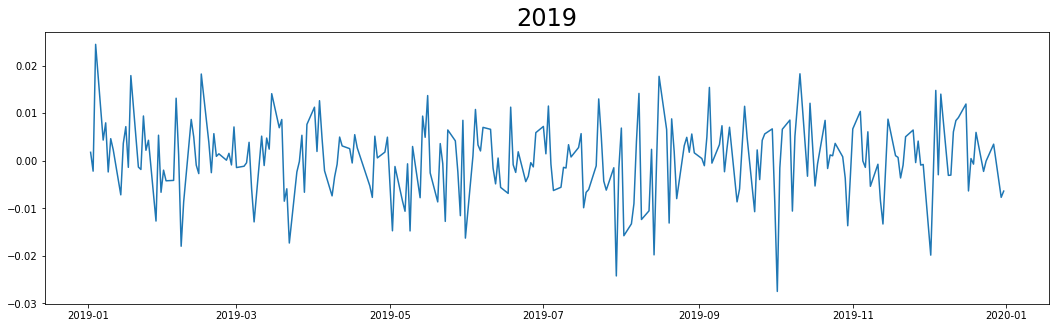

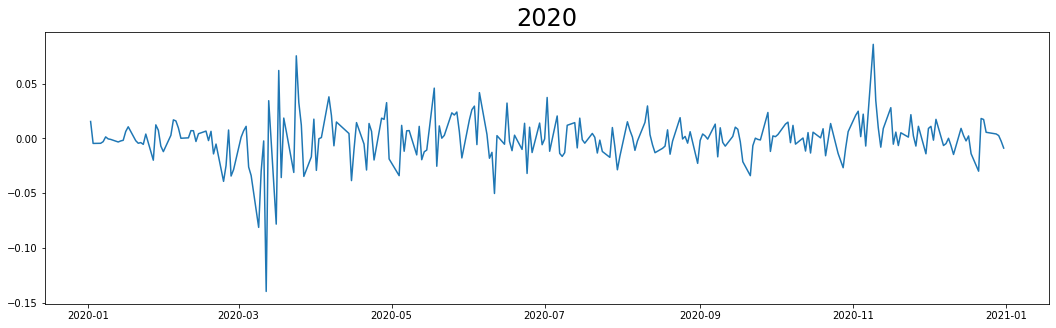

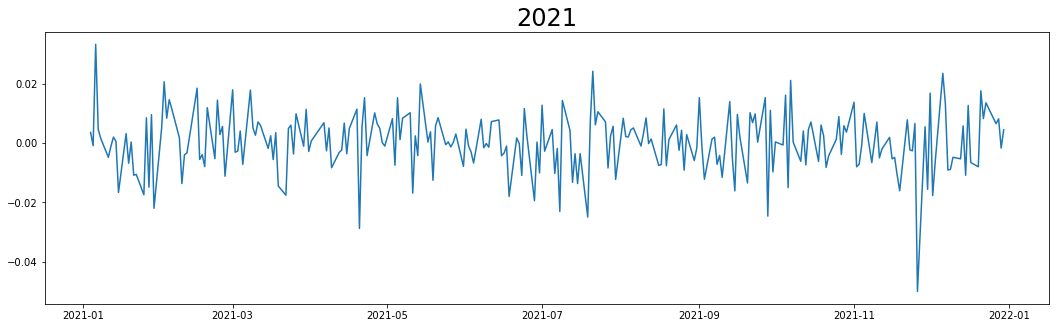

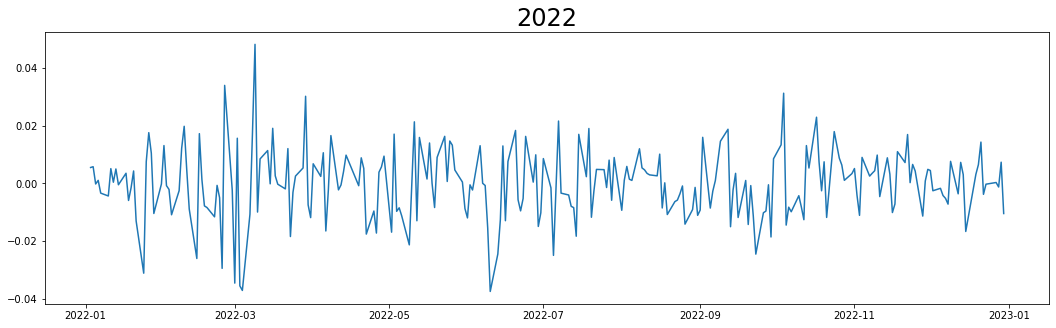

In [8]:
#Plot returns for every year 

plt.rcParams["figure.figsize"] = 18, 5

for year in set(dpx.index.year):
    plt.plot(dpx[["PXret"]].loc[dpx.index.year == year])
    plt.title(str(year), size = 24)
    plt.show()

In [9]:
# Creates a table with ADF and P-value for the three variables.

test = pd.DataFrame(columns=['Test','PX_test','Ret_test','1dif_test'])
test.Test = ['ADF','P_val']
test['PX_test']= adfuller(dpx.PX)[0:2]
test['Ret_test']= adfuller(dpx.PXret)[0:2]
test['1dif_test']= adfuller(dpx.PXdiff[1:])[0:2]
test.set_index('Test')

,PX_test,Ret_test,1dif_test
Test,,,
ADF,-2.324,-40.719,-40.639
P_val,0.164,0.000,0.000


In [11]:
# Data split = 90% of observations for train - 10% of observations for test

train = dpx[:int(0.9*len(mer))]
test = dpx[int(0.9*len(mer)):]


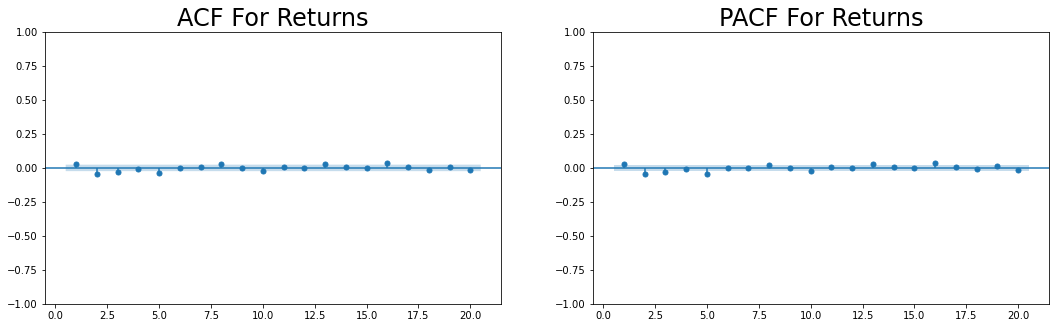

In [12]:
# Plota ACF and PACF of Returns

plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train.PXret, zero = False, lags = 20, ax = axes[0])
sgt.plot_pacf(train.PXret, zero = False, lags = 20, ax = axes[1])

axes[0].set_title("ACF For Returns", size = 24)
axes[1].set_title("PACF For Returns", size = 24)

plt.show()

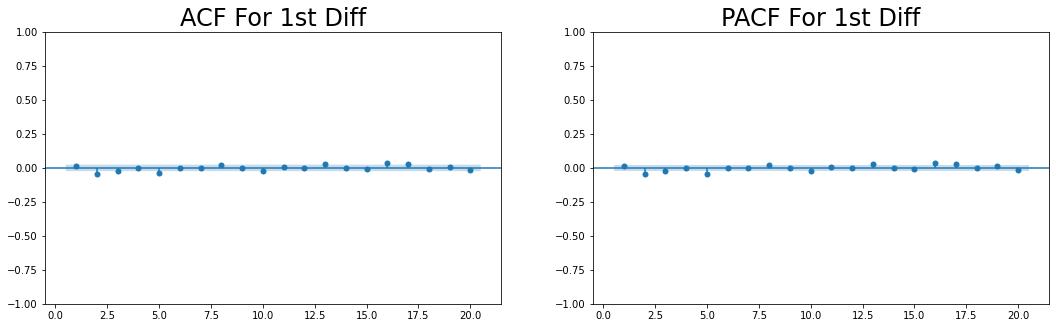

In [13]:
# Plota ACF and PACF of 1st Diff

plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train.PXdiff[1:], zero = False, lags = 20, ax = axes[0])
sgt.plot_pacf(train.PXdiff[1:], zero = False, lags = 20, ax = axes[1])

axes[0].set_title("ACF For 1st Diff", size = 24)
axes[1].set_title("PACF For 1st Diff", size = 24)

plt.show()

In [14]:
# Importing Required Package
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Model Definition
model0 = SARIMAX(train['PXret'].dropna(), order = (2, 0, 1))
# Model Training
model_fit = model0.fit()
# Summary of the model built
model_fit.summary() # for MADret ARMA(2,1) seems to be the optimal

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  PXret   No. Observations:                 6800
Model:               SARIMAX(2, 0, 1)   Log Likelihood               19740.547
Date:                Sat, 14 Jan 2023   AIC                         -39473.093
Time:                        17:23:33   BIC                         -39445.794
Sample:                             0   HQIC                        -39463.673
                               - 6800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6334      0.095      6.673      0.000       0.447       0.819
ar.L2         -0.0652      0.008     -7.790      0.000      -0.082      -0.049
ma.L1         -0.6013      0.095     -6.329      0.000      -0.788      -0.415
sigma2         0.0002   1.55e-06    113.952      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             13287.41
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

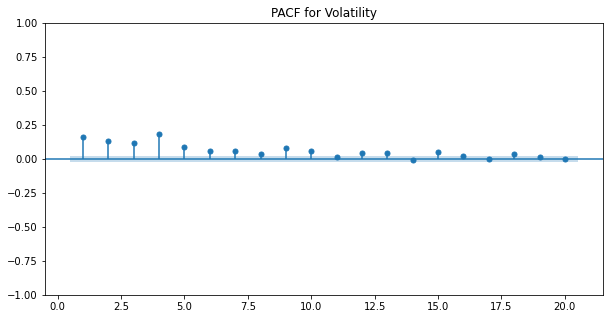

In [18]:
# Plota ACF and PACF of Volatility (for GARCH pq), significant drop after 4th lag

plt.rcParams["figure.figsize"] = 10, 5

#fig, axes = plt.subplots(0, 1)

#sgt.plot_acf(train.PXret**2, zero = False, lags = 20, ax = axes[0])
sgt.plot_pacf(train.PXret**2, zero = False, lags = 20, title = 'PACF for Volatility')

#axes[0].set_title("ACF For Returns", size = 24)
#p.set_title("PACF For Returns", size = 24)

plt.show() #sugests GARCH (4,4)

In [19]:
model = arch_model(train.PXret, p=3, q=0)
model_fit = model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 8.101140651523715e+21
Iteration:      2,   Func. Count:     21,   Neg. LLF: 981663.8166840093
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6.473399301300569e+22
Iteration:      4,   Func. Count:     50,   Neg. LLF: -5399.488109383716
Iteration:      5,   Func. Count:     59,   Neg. LLF: 72730637653269.12
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1096355108760.6772
Iteration:      7,   Func. Count:     87,   Neg. LLF: 1169305.5005040588
Iteration:      8,   Func. Count:    100,   Neg. LLF: 362355162176.84033
Iteration:      9,   Func. Count:    114,   Neg. LLF: -20219.15562822244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -20219.155617757126
            Iterations: 13
            Function evaluations: 114
            Gradient evaluations: 9


In [20]:
model_fit.summary() #alpha shows the lag version of the time series while beta stands for the lag of past volatility

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  PXret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                20219.2
Distribution:                  Normal   AIC:                          -40428.3
Method:            Maximum Likelihood   BIC:                          -40394.2
                                        No. Observations:                 6800
Date:                Sat, Jan 14 2023   Df Residuals:                     6799
Time:                        17:25:05   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.3249e-04  1.542e-04      3.453  5.554e-04 [2.302e-04,8.348e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.1920e-04  6.712e-06     17.761  1.422e-70 [1.061e-04,1.324e-04]
alpha[1]       0.0838  2.072e-02      4.042  5.304e-05   [4.314e-02,  0.124]
alpha[2]       0.0838  1.598e-02      5.241  1.596e-07   [5.243e-02,  0.115]
alpha[3]       0.0838  1.635e-02      5.121  3.038e-07   [5.170e-02,  0.116]
============================================================================

Covariance estimator: robust
"""

In [21]:
#Generating volatility predictions on the test set

rolling_predictions = []
test_size = len(test)

for i in range(test_size):
    trains = train.PXret[:-1]
    model = arch_model(trains, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [23]:
rolling_predictions = pd.Series(rolling_predictions, index=test.index)

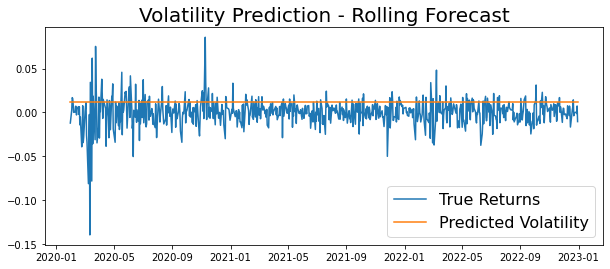

In [24]:
#Plot returns and volatility predictions. 
#Apparently is an error on the predictions since is predicting a constant value.

plt.figure(figsize=(10,4))
true, = plt.plot(test.PXret)
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)